In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
pip install quandl

In [8]:
import quandl

In [36]:
ethusd = quandl.get("BITFINEX/ETHUSD", authtoken="Jy-C4ogjQjicmLjayJuA")

In [37]:
btcusd = quandl.get("BITFINEX/BTCUSD", authtoken="Jy-C4ogjQjicmLjayJuA")

In [40]:
btceth = pd.merge(btcusd, ethusd, left_on = 'Date', right_on = 'Date', how = 'inner')

In [44]:
btceth = btceth.loc[:,['Last_x','Last_y']].rename(columns = {'Last_x':'BTC_last','Last_y':'ETH_last'})

In [48]:
btc = btceth.BTC_last.values.astype(float)
eth = btceth.ETH_last.values.astype(float)

btc = (btc - btc.mean())/btc.std()
eth = (eth - eth.mean())/eth.std()

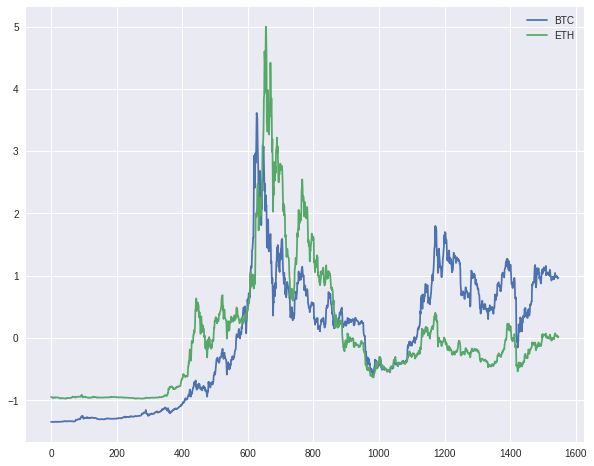

In [50]:
plt.subplots(figsize = (10,8))

plt.plot(btc)
plt.plot(eth)
plt.legend(['BTC','ETH'])
plt.show()

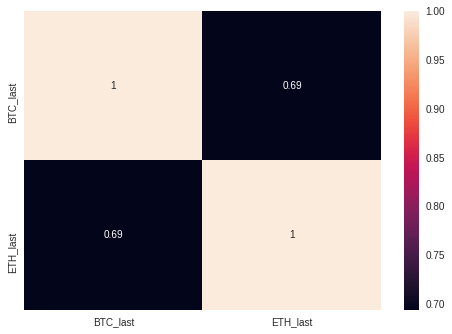

In [302]:
import seaborn as sn

sn.heatmap(btceth.corr(), annot = True)

In [195]:
def univariate_data(dataset, start, end, history_size, target_size):

  n_features = dataset.shape[1]

  data = []
  labels = []

  if not end:
    end = len(dataset)-target_size
  else:
    end = end - target_size
  
  start = start + history_size

  for i in range(start, end):
    data.append(np.array(dataset[i-history_size:i]).reshape(history_size, n_features))
    labels.append(dataset[i:i+target_size,1])

  labels = np.array(labels)
  labels = labels.reshape(labels.shape[0],)

  return np.array(data), labels

In [284]:
data_arr = btceth.values.astype(float)

In [198]:
TRAIN_SIZE = int(len(btceth)*0.95)

In [286]:
btc_mean = data_arr[:TRAIN_SIZE,0].mean()
btc_std = data_arr[:TRAIN_SIZE,0].std()

eth_mean = data_arr[:TRAIN_SIZE,1].mean()
eth_std = data_arr[:TRAIN_SIZE,1].std()

In [292]:
data_arr[:,0] = (data_arr[:,0] - btc_mean)/btc_std
data_arr[:,1] = (data_arr[:,1] - eth_mean)/eth_std

In [293]:
X_train, y_train = univariate_data(data_arr, 0, TRAIN_SIZE, 14, 1)
X_test, y_test = univariate_data(data_arr, TRAIN_SIZE, len(btceth),14, 1)

In [294]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(100).batch(20).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.batch(20).repeat()

In [295]:
lstm_model = tf.keras.Sequential([tf.keras.layers.LSTM(units = 14, input_shape = X_train.shape[1:]),
                                  tf.keras.layers.Dense(1)])

In [296]:
lstm_model.compile(optimizer='adam', loss = 'mse')

In [297]:
history = lstm_model.fit(train_dataset, epochs = 10, steps_per_epoch=1000, validation_data=val_dataset, validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0806 - val_loss: 0.0018
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0131 - val_loss: 0.0010
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0111 - val_loss: 8.4460e-04
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100 - val_loss: 7.5952e-04
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0083 - val_loss: 6.9532e-04
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0083 - val_loss: 0.0011
Epoch 9/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0074 - val_loss: 7.2705e-04
Epoch 10/10
1000/1000 [==============================] - 6s 6ms/st

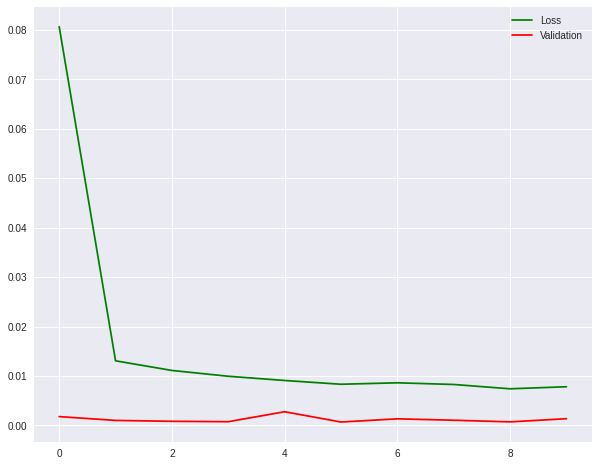

In [299]:
plt.subplots(figsize = (10,8))

plt.plot(history.history['loss'], color = 'green')
plt.plot(history.history['val_loss'], color = 'red')

plt.legend(['Loss','Validation'])
plt.show()

loss function is decreasing while validation loss stays the same. If I understand correctly than it means I should reduce number of epochs.

In [244]:
def timesteps(x):
  return range(-len(x),0)

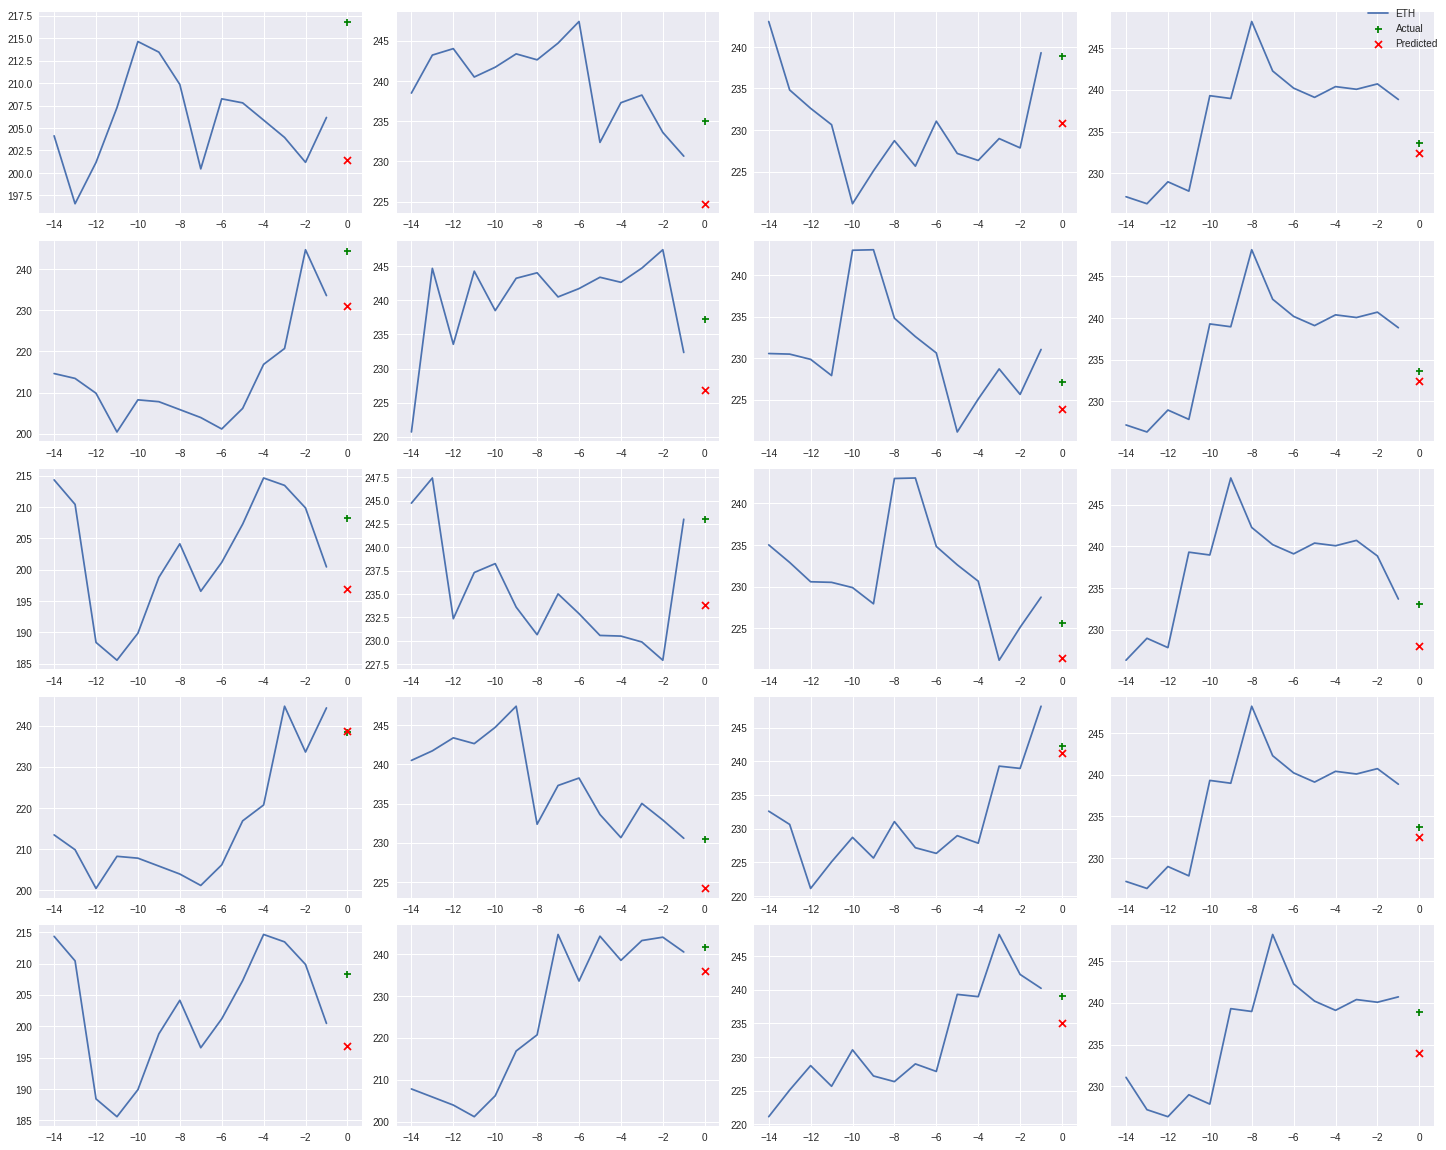

In [422]:
np.random.seed()

fig, ax = plt.subplots(5, 4, figsize = (20,16))

for i, (x,y) in enumerate(val_dataset.take(20)):
  
  random_ = np.random.randint(len(y.numpy()))
  y_ = y.numpy()
  y_ = y_[random_] * eth_std + eth_mean

  y_hat = lstm_model.predict(np.array([x[random_]]))[0][0]*eth_std + eth_mean
  history = x[random_].numpy()*eth_std+eth_mean

  row = int(i/4)
  col = i % 4

  ax[row][col].plot(timesteps(history), history[:,1])
  ax[row][col].scatter(0, y_, marker = '+', color ='green')
  ax[row][col].scatter(0, y_hat, marker = 'x', color = 'red')

fig.legend(['ETH','Actual','Predicted'])  
plt.tight_layout()

Lets try and predict ETH price for tomrrow (20 July)

In [312]:
july_20_price = btceth.iloc[-14:,:].values.astype(float)
july_20_price[:,0] = (july_20_price[:,0] - btc_mean) / btc_std
july_20_price[:,1] = (july_20_price[:,1] - eth_mean) / eth_std

In [314]:
lstm_model.predict(np.array([july_20_price]))[0][0]*eth_std + eth_mean

228.33754312175608

I want to try and see how many times could the network predict just the direction correctly. I think it is the most important factor when trying to predict time series data. Of course, one of the pitfall of such models is that would probably never be able to predict a crash or a huge surge in prices.

In [353]:
def hit_or_miss(previous, actual, expected):
  if expected > previous: #expecting increase
    if actual > previous:
      return 1
  elif expected < previous: #expecting decrease
    if actual < previous:
      return 1
  return 0

In [429]:
from scipy.stats import binom

In [440]:
batch_size = 20

totals = 0
hits_totals = 0

for x,y in val_dataset.take(50):
  total = 0
  hit = 0 
  prediction = lstm_model.predict(x)*eth_std+eth_mean
  actual = y*eth_std+eth_mean
  miss = actual - prediction
  for i in range(0,len(y)):
    previous = x.numpy()[i][13,1]*eth_std + eth_mean
    y_hat = prediction[:,0][i]
    y_ = actual.numpy()[i]
    total += 1
    hit += hit_or_miss(previous, y_, y_hat)
    #print('Predicted: %.1f, Actual: %.1f, Previous: %.1f' % (prediction[:,0][i], actual.numpy()[i], previous))

  #print('Total in batch: {}, Direction hit: {}'.format(total, hit))
  totals += total
  hits_totals += hit

print('The network has predicted correctly the direction in %.3f of the samples' % (hits_totals/totals))
print('Probability of hitting direction correctly in %.f or less out of %.f trials is %.3f '% (hits_totals , totals,binom.cdf(hits_totals, totals, 0.5)))

The network has predicted correctly the direction in 0.553 of the samples
Probability of hitting exactly 440 or less out of 796 trials is 0.999 


I think one of the problems of classical statistics tests is that they are very unreliable when using a large dataset.

So far 55 is better than random chance but I still don't believe the model. At 60, I can actually trust it.